In [1]:
import sys
sys.path.append('../')

from nonlinear_system.ct_system import ContinuousTimeSystem
from nonlinear_system.epidem_odes import SIR, SIR_t
from lib.estimate import get_poly_estimates, get_gauss_estimates
from lib.simulate import simulate
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
mu = 0.02/365
gamma = 1/20
beta = 17*(mu+gamma)*5

S0 = 0.06
I0 = 0.01

num_days = 20
sampling_dt = 1
integration_dt = 0.01

sir_ode = SIR(mu=mu, beta=beta, gamma=gamma)
x0 = np.array([S0, I0])

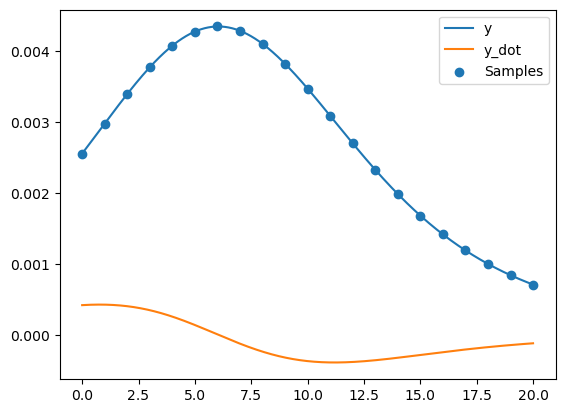

In [3]:
time, x, y_d, t_samples, y_samples = simulate(sir_ode, x0, integration_dt, sampling_dt, num_days)

plt.plot(time, y_d.T, label=["y", "y_dot"])
plt.scatter(t_samples, y_samples, label="Samples")
plt.legend()
plt.show()

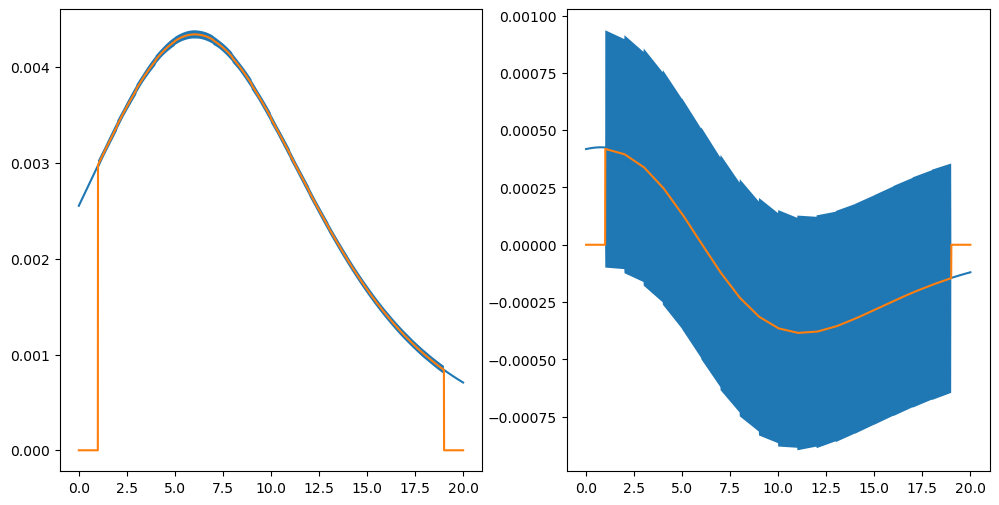

In [4]:
window_size = 4 # Number of samples in window
delay = 1
d = 2
nderivs = 2

Y_max = [0.005, 0.0005, 5e-05, 0.0005]

y_hat_pol, y_bound_pol = get_poly_estimates(t_samples, y_samples, Y_max, window_size, sampling_dt, d, delay, nderivs, integration_dt)        

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(time, y_d[0])
plt.plot(time, y_hat_pol[0])
plt.fill_between(time, y_hat_pol[0]-y_bound_pol[0], y_hat_pol[0]+y_bound_pol[0])

plt.subplot(1,2,2)
plt.plot(time, y_d[1])
plt.plot(time, y_hat_pol[1])
plt.fill_between(time, y_hat_pol[1]-y_bound_pol[1], y_hat_pol[1]+y_bound_pol[1])
plt.show()

g:\UCLA\Research\Observer Design\polynomial_observers\epidemiology\..\nonlinear_system\epidem_odes.py:177: RuntimeWarning: invalid value encountered in divide
  y_d[0]/(self.beta*sol),


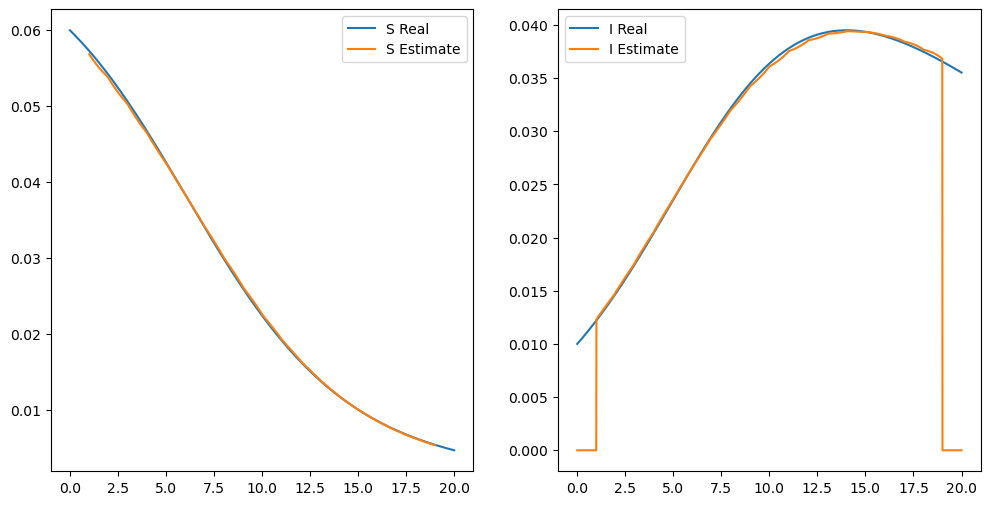

In [5]:
x_hat_pol = sir_ode.invert_output(t=0, y_d=y_hat_pol)

states = ["S","I"]

plt.figure(figsize=(12,6))
for j in range(2):
    plt.subplot(1,2,j+1)
    plt.plot(time, x[j], label=states[j]+" Real")
    plt.plot(time, x_hat_pol[j], label=states[j]+" Estimate")
    plt.legend()
plt.show()

In [6]:
y0 = y_d[0]
y1 = np.gradient(y0, integration_dt)
y2 = np.gradient(y1, integration_dt)
y3 = np.gradient(y2, integration_dt)

print(np.max(y0))
print(np.max(y1))
print(np.max(y2))
print(np.max(y3))

0.004343895998215301
0.00042516828494998556
4.011684236649056e-05
0.0004622776411883703


## Time Varying

In [7]:
mu = 0.02
gamma = 365/20
beta = 17*(mu+gamma)
nu = 0.4
w = 2.4

S0 = 0.06
I0 = 0.001

num_years = 24
sampling_dt = 0.01
integration_dt = 0.001

sir_ode = SIR_t(mu=mu, beta=beta, gamma=gamma, nu=nu, w=w)
x0 = np.array([S0, I0])

time, x, y_d, t_samples, y_samples = simulate(sir_ode, x0, integration_dt, sampling_dt, num_years)

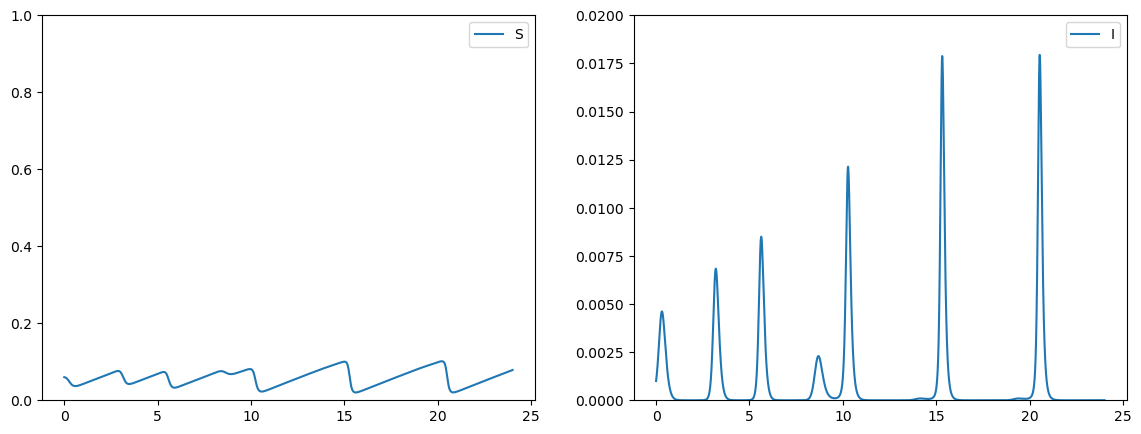

In [8]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(time, x[0], label="S")
plt.ylim([0,1])
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, x[1], label="I")
plt.ylim([0,0.02])
plt.legend()

plt.show()

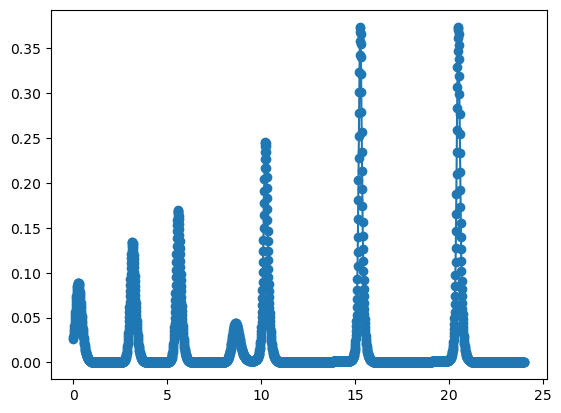

In [9]:
plt.plot(time, y_d[0])
plt.scatter(t_samples, y_samples)
plt.show()

In [10]:
y = y_d[0]
for i in range(5):
    print(f"Max value of {i}th derivative = {np.max(np.abs(y))}")
    y = np.gradient(y, integration_dt)

Max value of 0th derivative = 0.3743161005451076
Max value of 1th derivative = 2.502869973496913
Max value of 2th derivative = 56.275173999087436
Max value of 3th derivative = 1081.1906139759362
Max value of 4th derivative = 166351.39654815054


### Polynomial Bounds

In [18]:
window_size = 4 # Number of samples in window
delay = 1
d = 3
nderivs = 2

Y_max = [0.4, 2.7, 60, 1010, 170000]

y_hat_pol, y_bound_pol = get_poly_estimates(t_samples, y_samples, Y_max, window_size, sampling_dt, d, delay, nderivs, integration_dt)

In [19]:
y_hat_gaus, y_bound_gaus = get_gauss_estimates(t_samples, y_samples, Y_max, window_size, sampling_dt, d, delay, nderivs, integration_dt, d=d)

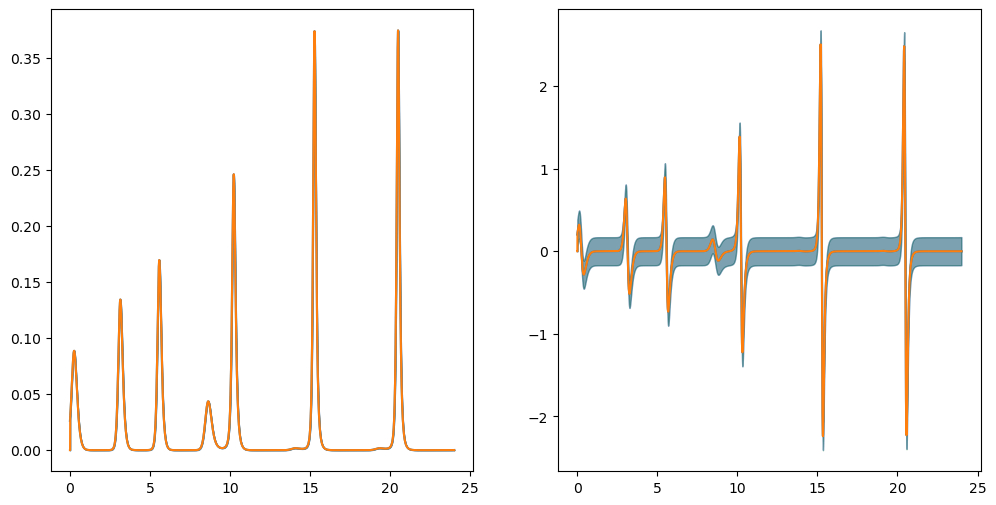

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(time, y_d[0])
plt.plot(time, y_hat_pol[0])
plt.fill_between(time, y_hat_gaus[0]-y_bound_gaus[0], y_hat_gaus[0]+y_bound_gaus[0], alpha=0.3, color='blue')
plt.fill_between(time, y_hat_pol[0]-y_bound_pol[0], y_hat_pol[0]+y_bound_pol[0], alpha=0.3, color='green')

plt.subplot(1,2,2)
plt.plot(time, y_d[1])
plt.plot(time, y_hat_pol[1])
plt.fill_between(time, y_hat_gaus[1]-y_bound_gaus[1], y_hat_gaus[1]+y_bound_gaus[1], alpha=0.3, color='blue')
plt.fill_between(time, y_hat_pol[1]-y_bound_pol[1], y_hat_pol[1]+y_bound_pol[1], alpha=0.3, color='green')
plt.show()

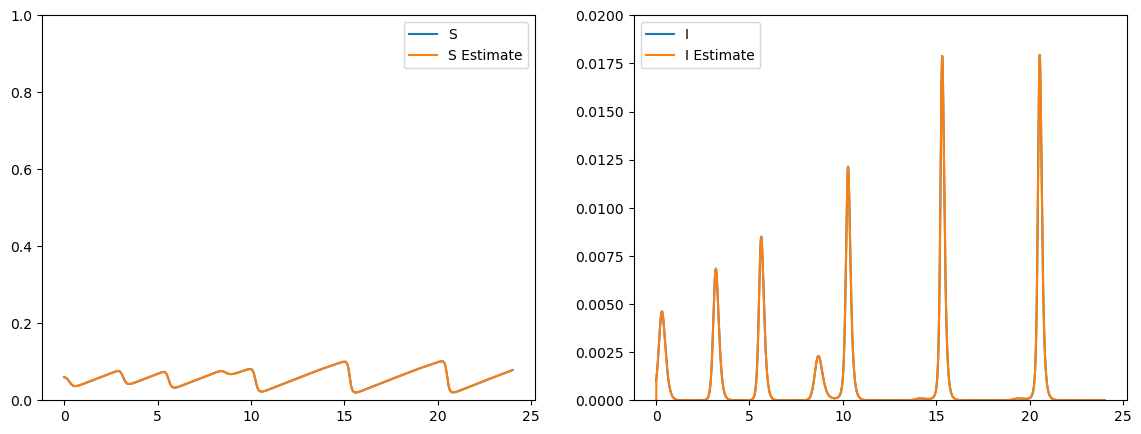

In [25]:
x_hat_pol = sir_ode.invert_output(time, y_hat_pol)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(time, x[0], label="S")
plt.plot(time, x_hat_pol[0], label="S Estimate")
plt.ylim([0,1])
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, x[1], label="I")
plt.plot(time, x_hat_pol[1], label="I Estimate")
plt.ylim([0,0.02])
plt.legend()

plt.show()

In [26]:
def get_x_bounds(y_hat, y_bound):
    y_min = y_hat - y_bound
    y_max = y_hat + y_bound

    a = sir_ode.invert_output(time, y_min)
    b = sir_ode.invert_output(time, y_max)
    c = sir_ode.invert_output(time, np.array([y_max[0], y_min[1]]))
    d = sir_ode.invert_output(time, np.array([y_min[0], y_max[1]]))

    x_min = np.minimum.reduce([a,b,c,d])
    x_max = np.maximum.reduce([a,b,c,d])
    return x_min, x_max

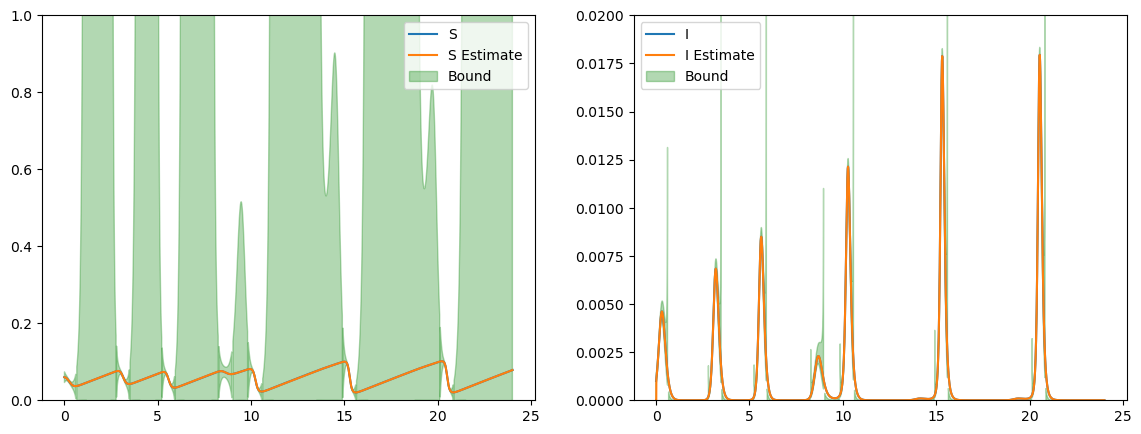

In [27]:
x_min_pol, x_max_pol = get_x_bounds(y_hat_pol, y_bound_pol)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(time, x[0], label="S")
plt.plot(time, x_hat_pol[0], label="S Estimate")
plt.fill_between(time, x_min_pol[0], x_max_pol[0], alpha=0.3, color='green', label="Bound")
plt.ylim([0,1])
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, x[1], label="I")
plt.plot(time, x_hat_pol[1], label="I Estimate")
plt.fill_between(time, x_min_pol[1], x_max_pol[1], alpha=0.3, color='green', label="Bound")
plt.ylim([0,0.02])
plt.legend()

plt.show()